# `nb08b`: Model comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Model comparison using Bayes factors

## Marginal likelihood

$$p(\theta | x, \mathcal{M}_1) = \frac{p(x | \theta, \mathcal{M}_1) p(\theta | \mathcal{M}_1)}{p(x | \mathcal{M}_1)}$$

$$p(x | \mathcal{M}_1) = \int p(x | \theta, \mathcal{M}_1) p(\theta | \mathcal{M}_1) d\theta$$

We assume a study where we assess the number of successes observed in a fixed number of trials. For example, we have 80 successes out of 100 trials. 

A simple model of this data can be built by assuming that the data is distributed according to a binomial distribution. In a binomial distribution, $n$ independent experiments are performed and the result of each experiment is succesful with probability $\theta$. Then, the binomial distribution is the probability distribution of the number of successes $k$.

In [2]:
# Model 1
from scipy.stats import binom

def likelihood1(theta, k, n):
    return binom.pmf(k, n, theta)

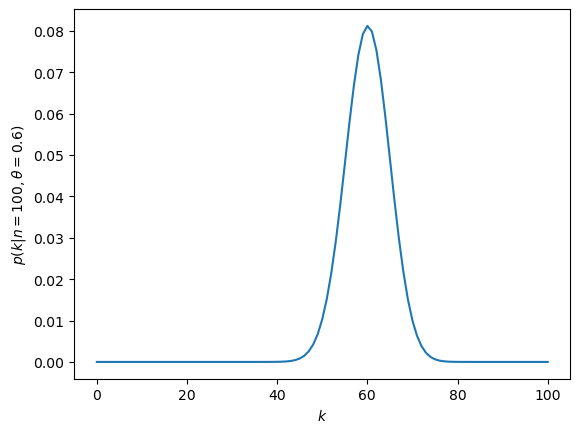

In [3]:
fig = plt.figure()
ax = plt.axes()

theta = 0.6
n = 100

ks = range(0, n+1)
ax.plot(ks, likelihood1(theta, ks, n))
ax.set(xlabel=r"$k$", ylabel=r"$p(k | n={}, \theta={})$".format(n, theta))

plt.show()

Suppose we have prior information about the probability parameter $\theta$, encoded as a Beta distribution of parameters $a$ and $b$.

In [4]:
from scipy.stats import beta

a = 4
b = 2

def prior1(theta):
    return beta.pdf(theta, a=a, b=b)

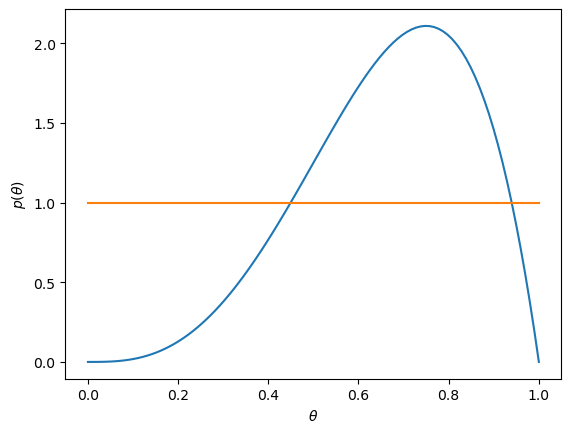

In [8]:
fig = plt.figure()
ax = plt.axes()

thetas = np.linspace(0, 1, num=100)
ax.plot(thetas, prior1(thetas))
ax.plot(thetas, prior2(thetas))
ax.set(xlabel=r"$\theta$", ylabel=r"$p(\theta)$")

plt.show()

Then the marginal likelihood is given by the integral of the product of the likelihood and the prior:

In [6]:
from scipy.integrate import quad
ml1, _ = quad(lambda theta: likelihood1(theta, k=80, n=n) * prior1(theta), 0, 1)
ml1

0.019982271038244702

In [9]:
# Model 2: wider prior
def prior2(theta):
    return beta.pdf(theta, a=1, b=1)

ml2, _ = quad(lambda theta: likelihood1(theta, k=80, n=n) * prior2(theta), 0, 1)
ml2

0.009900990099009892

In [10]:
# Model 3: more complex likelihood
from scipy.stats import betabinom, lognorm

def likelihood3(alpha, beta, k, n):
    return betabinom.pmf(k, n, alpha, beta)

def prior3(alpha, beta):
    return lognorm.pdf(alpha, 100) * lognorm.pdf(beta, 100)

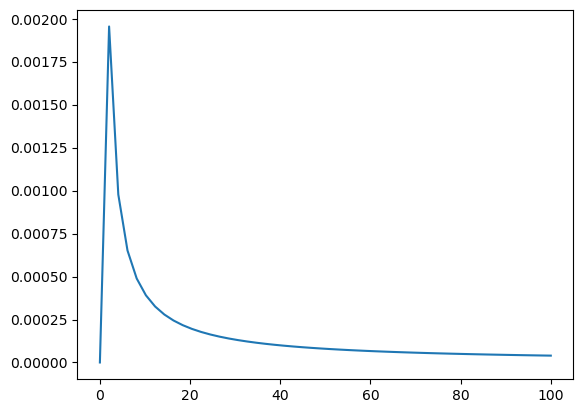

In [11]:
fig = plt.figure()
ax = plt.axes()

vs = np.linspace(0, 100)
ax.plot(vs, lognorm.pdf(vs, 100))

plt.show()

In [12]:
from scipy.integrate import dblquad
ml3, _ = dblquad(lambda alpha, beta: likelihood3(alpha, beta, k=80, n=n) * prior3(alpha, beta), 0, np.inf, 0, np.inf)
ml3

/home/glouppe/anaconda3/envs/dats0001/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


5.750979990594095e-06

In [11]:
print("Model 1:", ml1)
print("Model 2:", ml2)
print("Model 3:", ml3)

Model 1: 0.019982271038244702
Model 2: 0.009900990099009892
Model 3: 5.750979990594095e-06


## Bayes factor

$$\text{BF}_{1,2} = \frac{p(x | \mathcal{M}_1)}{p(x | \mathcal{M}_2)}$$

In [12]:
print("BF(1,2):", ml1 / ml2, np.log(ml1 / ml2))
print("BF(1,3):", ml1 / ml3, np.log(ml1 / ml3))
print("BF(2,3):", ml2 / ml3, np.log(ml2 / ml3))

BF(1,2): 2.0182093748627166 0.7022106701979013
BF(1,3): 3474.585387347256 8.153230437886936
BF(2,3): 1721.617900810517 7.451019767689035


If we want to know, given the data $x$, how much more probable model $\mathcal{M}_1$ is than model $\mathcal{M}_2$, then we need the prior odds:

$$\frac{p(\mathcal{M}_1 | x)}{p(\mathcal{M}_2 | x)} = \frac{p(\mathcal{M}_1)}{p(\mathcal{M}_2)} \frac{p(x | \mathcal{M}_1)}{p(x | \mathcal{M}_2)} = \frac{p(\mathcal{M}_1)}{p(\mathcal{M}_2)} \text{BF}_{1,2}$$

![](figures/nb11/bf.png)

<div class="alert alert-success">
    
**Exercise**. Using the light speed experiment data from `nb10`, compare:
- $\mathcal{M}_1: p(x | \mu, \sigma) = \mathcal{N}(x | \mu, \sigma), p(\mu, \sigma) = \mathcal{U}$
- $\mathcal{M}_2: p(x | \mu, \sigma, a) = \text{skewnorm}(x | \mu, \sigma, a), p(\mu, \sigma, a) = \mathcal{U}$.
    
</div>

<div class="alert alert-success">
    
**Exercise**. How to compute the Bayes factor for more complicated models?

</div>

# Cross-validation

A popular way to evaluate and compare models is on their ability to make predictions for future or unseen observations $x_\text{pred}$, using what we learned from the observed data $\{x\} = \{x_1, ..., x_n\}$.

## Expected log predictive density

Let $$u(\mathcal{M}_1, x_\text{pred}) = \log p(x_\text{pred} | \{x\}, \mathcal{M}_1)$$

$$\log p(x_\text{pred} | \{x\}, \mathcal{M}_1) = \log \int p(x_\text{pred} | \theta, \mathcal{M}_1) p(\theta | \{x\}, \mathcal{M}_1) d\theta $$

$$\text{elpd} = u(\mathcal{M}_1) = \mathbb{E}_{p_\text{true}(x_\text{pred})} [ \log p(x_\text{pred} | \{x\}, \mathcal{M}_1) ]$$

where $p_\text{true}$ is the true data generating distribution. 

The model with the highest $\text{elpd}$ is the the model with the predictions that are the closest to the ones of the true data generating process.

But we we don't know $p_\text{true}$! Solution: use the $n$ observations from $\{x\}$:

$$\widehat{\text{elpd}} = \frac{1}{n} \sum_{i=1}^n \log p(x_i | \{x\}, \mathcal{M}_1)$$

In [13]:
# Example
theta_true = np.array([1.0, 3.0])
p_true = beta(a=theta_true[0], b=theta_true[1])

np.random.seed(42)
n = 50
xs = p_true.rvs(n)

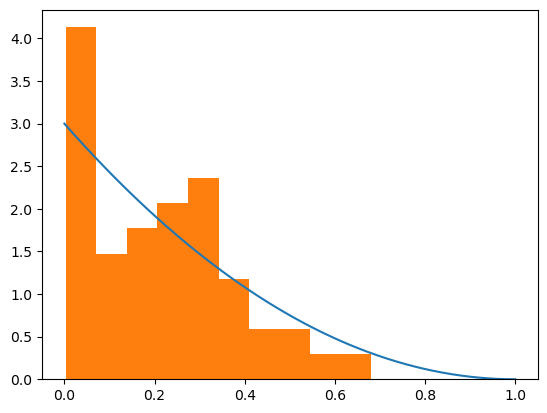

In [14]:
fig = plt.figure()
ax = plt.axes()

vs = np.linspace(0, 1)
ax.plot(vs, p_true.pdf(vs))
ax.hist(xs, density=True)

plt.show()

In [18]:
# Model 1
def log_likelihood(theta, x):
    return beta(theta[0], theta[1]).logpdf(x).sum()

def log_prior(theta):
    return lognorm.pdf(theta[0], 10) * lognorm.pdf(theta[1], 10)

def log_posterior(theta, x):
    if theta[0] <= 0 or theta[1] <= 0:
        return -np.inf
    else:                          
        return log_likelihood(theta, x) + log_prior(theta)

In [19]:
# Fit the posterior
import emcee
pos = np.array([1.0, 1.0]) + 0.1 * np.random.randn(5, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xs,))
sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 336.05it/s]


4500


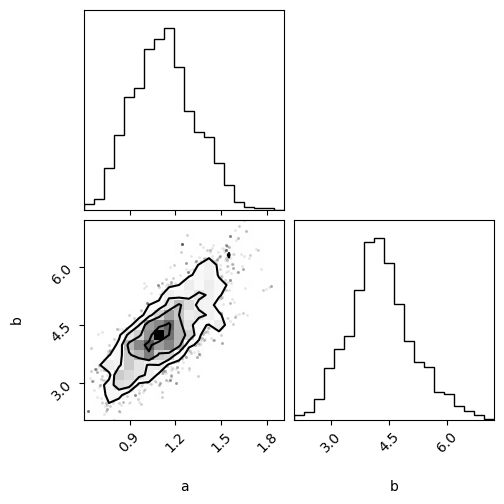

In [20]:
import corner
thetas = sampler.get_chain(flat=True, discard=100)
print(len(thetas))
fig = corner.corner(thetas, labels=["a", "b"])

In [21]:
# elpd
def log_posterior_predictive(x_i, thetas):
    return np.mean([log_likelihood(theta, x_i) for theta in thetas])

def elpd(xs, thetas):
    return np.mean([log_posterior_predictive(x_i, thetas) for x_i in xs])

subset = np.random.permutation(len(thetas))[:500]
elpd(xs, thetas[subset])

0.5654324527537117

<div class="alert alert-success">
    
**Exercise**. What's wrong with this procedure?
    
</div>

## K-fold validation

In [22]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)
elpd_test = []

for train_idx, test_idx in kf.split(xs):
    # posterior fit
    pos = np.array([1.0, 1.0]) + 0.1 * np.random.randn(5, 2)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xs[train_idx],))
    sampler.run_mcmc(pos, 1000, progress=True);
    thetas = sampler.get_chain(flat=True, discard=100)
    
    # epld
    subset = np.random.permutation(len(thetas))[:500]
    elpd_test.append(elpd(xs[test_idx], thetas[subset]))

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 331.09it/s]


In [23]:
elpd_test

[0.8105294047367207,
 0.027101230705309565,
 0.7385731299975092,
 0.6418294451361742,
 0.6790205968563633,
 0.4567709801665624,
 0.9205155545551229,
 0.6293925926367321,
 0.012135612593329893,
 0.4072099427231815]

In [24]:
np.mean(elpd_test), np.std(elpd_test)

(0.5323078490107005, 0.2933890025426623)

<div class="alert alert-success">
    
**Exercise**. Evaluate the K-Fold estimate as a function of $K$. 
    
</div>